# Анализ отзывов на банки

В данных представлены отзывы на банки с сайта [banki.ru](https://www.banki.ru/)
- body - сам отзыв
- title - название отзыва
- rating - оценка по отзыву, варьируется от 1 до 5
- bank_name - название банка
- date - дата публикации отзыва

Необходимо EDA (Exploratory Data Analysis) по этим данным и сделать несколько выводов (приветствуются визуализации):
- назвать топ-15 банков по числу отзывов
- какой банк из числа топ-15 по отзывов имеет самый высокий средний рейтинг?
- сделать выводы об изменении среднего рейтинга банков по месяцам из топ-5 банков по числу отзывов
- нет ли в данных в целом каких-то странностей на ваш взгляд?
- дополнительный EDA на ваше усмотрение, возможные интересные наблюдения

Необходимо выбрать метрику и построить бинарный классификатор отзывов, добившись при этом лучшей метрики на валидационной выборке (отзывы >=3 считать положительными, <3 - отрицательными)

Будет плюсом визуализация результатов работы модели (ответ на вопрос: почему построенная модель считает этот отзыв положительным или отрицательным?)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os

In [2]:
data = pd.read_csv('data/parsed_reviews3.csv')
data.head()

,body,title,rating,bank_name,date
0,&lt;p&gt;Добрый день&lt;/p&gt;\r\n&lt;p&gt;пиш...,Заблокировали средства,1,Еком Банк,2023-01-03 12:46:11
1,&lt;p&gt;При возврате просроченной задолженнос...,Возврат просроченной задолженномти,1,Тинькофф Банк,2023-01-03 12:31:46
2,&lt;p&gt;07.09.22 ю была оформлена кредитная к...,"Ошибочное начисление комиссии, затягивание про...",1,Банк Открытие,2023-01-03 12:23:11
3,&lt;p&gt;Новый год начинается с приятностей)&l...,Клиентоориентиванность 10 из 10,5,Тинькофф Банк,2023-01-03 12:16:07
4,&lt;p&gt;Увидела на сайте Газпромбанка акцию с...,Как Газпромбанк обманывает клиентов с акционны...,1,Газпромбанк,2023-01-03 12:12:36


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92735 entries, 0 to 92734
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   body       92735 non-null  object
 1   title      92735 non-null  object
 2   rating     92735 non-null  int64 
 3   bank_name  92735 non-null  object
 4   date       92735 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.5+ MB


## Preproccessing the data

#### Сперва очищу данные от тегов

In [5]:
print(data.iloc[0]['body'])

&lt;p&gt;Добрый день&lt;/p&gt;
&lt;p&gt;пишу сюда для более скорого разрешения вопроса &lt;/p&gt;
&lt;p&gt;Пополнил через Юмани Озон банк&lt;/p&gt;
&lt;p&gt;после чего вывести деньги не дал, сославшись на сомнительные операции(понимаю, могло так показаться)&lt;/p&gt;
&lt;p&gt;просто озон удобен тем что можно пополнить его через QIWI и Юмани без комиссии, за что ценю&lt;/p&gt;
&lt;p&gt;документы предоставил, причины переводов тоже&lt;/p&gt;
&lt;p&gt;надеюсь на разблокировку, если не для переводов, то хотя бы для оплаты товаров&lt;/p&gt;
&lt;p&gt;для привлечения внимания пока ставлю 1&lt;/p&gt;
&lt;p&gt;после решения вопроса поставлю 5&lt;/p&gt;


In [6]:
import re
import html

data_preprocessed = data.copy()

def remove_tags(input_text):
    clean_text = html.unescape(input_text)
    clean_text = re.sub(r'<.*?>', '', clean_text)
    clean_text = clean_text.replace('\r\n', ' ')
    clean_text = clean_text.replace('\xa0', ' ')
    return clean_text

data_preprocessed['body'] = data_preprocessed['body'].apply(remove_tags)
data_preprocessed['title'] = data_preprocessed['title'].apply(remove_tags)

##### Взглянем на ДО и ПОСЛЕ

In [7]:
print(f'До удаления тегов: \n\n{data.iloc[0]["body"]}')

print(f'\nПосле удаления тегов: \n\n{data_preprocessed.iloc[0]["body"]}')

До удаления тегов: 

&lt;p&gt;Добрый день&lt;/p&gt;
&lt;p&gt;пишу сюда для более скорого разрешения вопроса &lt;/p&gt;
&lt;p&gt;Пополнил через Юмани Озон банк&lt;/p&gt;
&lt;p&gt;после чего вывести деньги не дал, сославшись на сомнительные операции(понимаю, могло так показаться)&lt;/p&gt;
&lt;p&gt;просто озон удобен тем что можно пополнить его через QIWI и Юмани без комиссии, за что ценю&lt;/p&gt;
&lt;p&gt;документы предоставил, причины переводов тоже&lt;/p&gt;
&lt;p&gt;надеюсь на разблокировку, если не для переводов, то хотя бы для оплаты товаров&lt;/p&gt;
&lt;p&gt;для привлечения внимания пока ставлю 1&lt;/p&gt;
&lt;p&gt;после решения вопроса поставлю 5&lt;/p&gt;

После удаления тегов: 

Добрый день пишу сюда для более скорого разрешения вопроса  Пополнил через Юмани Озон банк после чего вывести деньги не дал, сославшись на сомнительные операции(понимаю, могло так показаться) просто озон удобен тем что можно пополнить его через QIWI и Юмани без комиссии, за что ценю документы предоста

#### Теперь приведем текст к нижнему регистру и проведем токенизацию (все токены будут разделены между собой пробелами)

In [8]:
from nltk.tokenize import WordPunctTokenizer

tokenizer = WordPunctTokenizer()

data_preprocessed['body'] = data_preprocessed['body'].apply(lambda x: ' '.join(tokenizer.tokenize(x)).lower())
data_preprocessed['title'] = data_preprocessed['title'].apply(lambda x: ' '.join(tokenizer.tokenize(x)).lower())

In [9]:
print(data_preprocessed.iloc[0]['body'])

добрый день пишу сюда для более скорого разрешения вопроса пополнил через юмани озон банк после чего вывести деньги не дал , сославшись на сомнительные операции ( понимаю , могло так показаться ) просто озон удобен тем что можно пополнить его через qiwi и юмани без комиссии , за что ценю документы предоставил , причины переводов тоже надеюсь на разблокировку , если не для переводов , то хотя бы для оплаты товаров для привлечения внимания пока ставлю 1 после решения вопроса поставлю 5


## EDA

### Обязательный EDA

/tmp/ipykernel_22469/3675944032.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0, 0].set_xticklabels(top_banks.index, rotation=45, ha='right')
/tmp/ipykernel_22469/3675944032.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0, 1].set_xticklabels(top15_banks_avg_rating.index, rotation=45, ha='right')


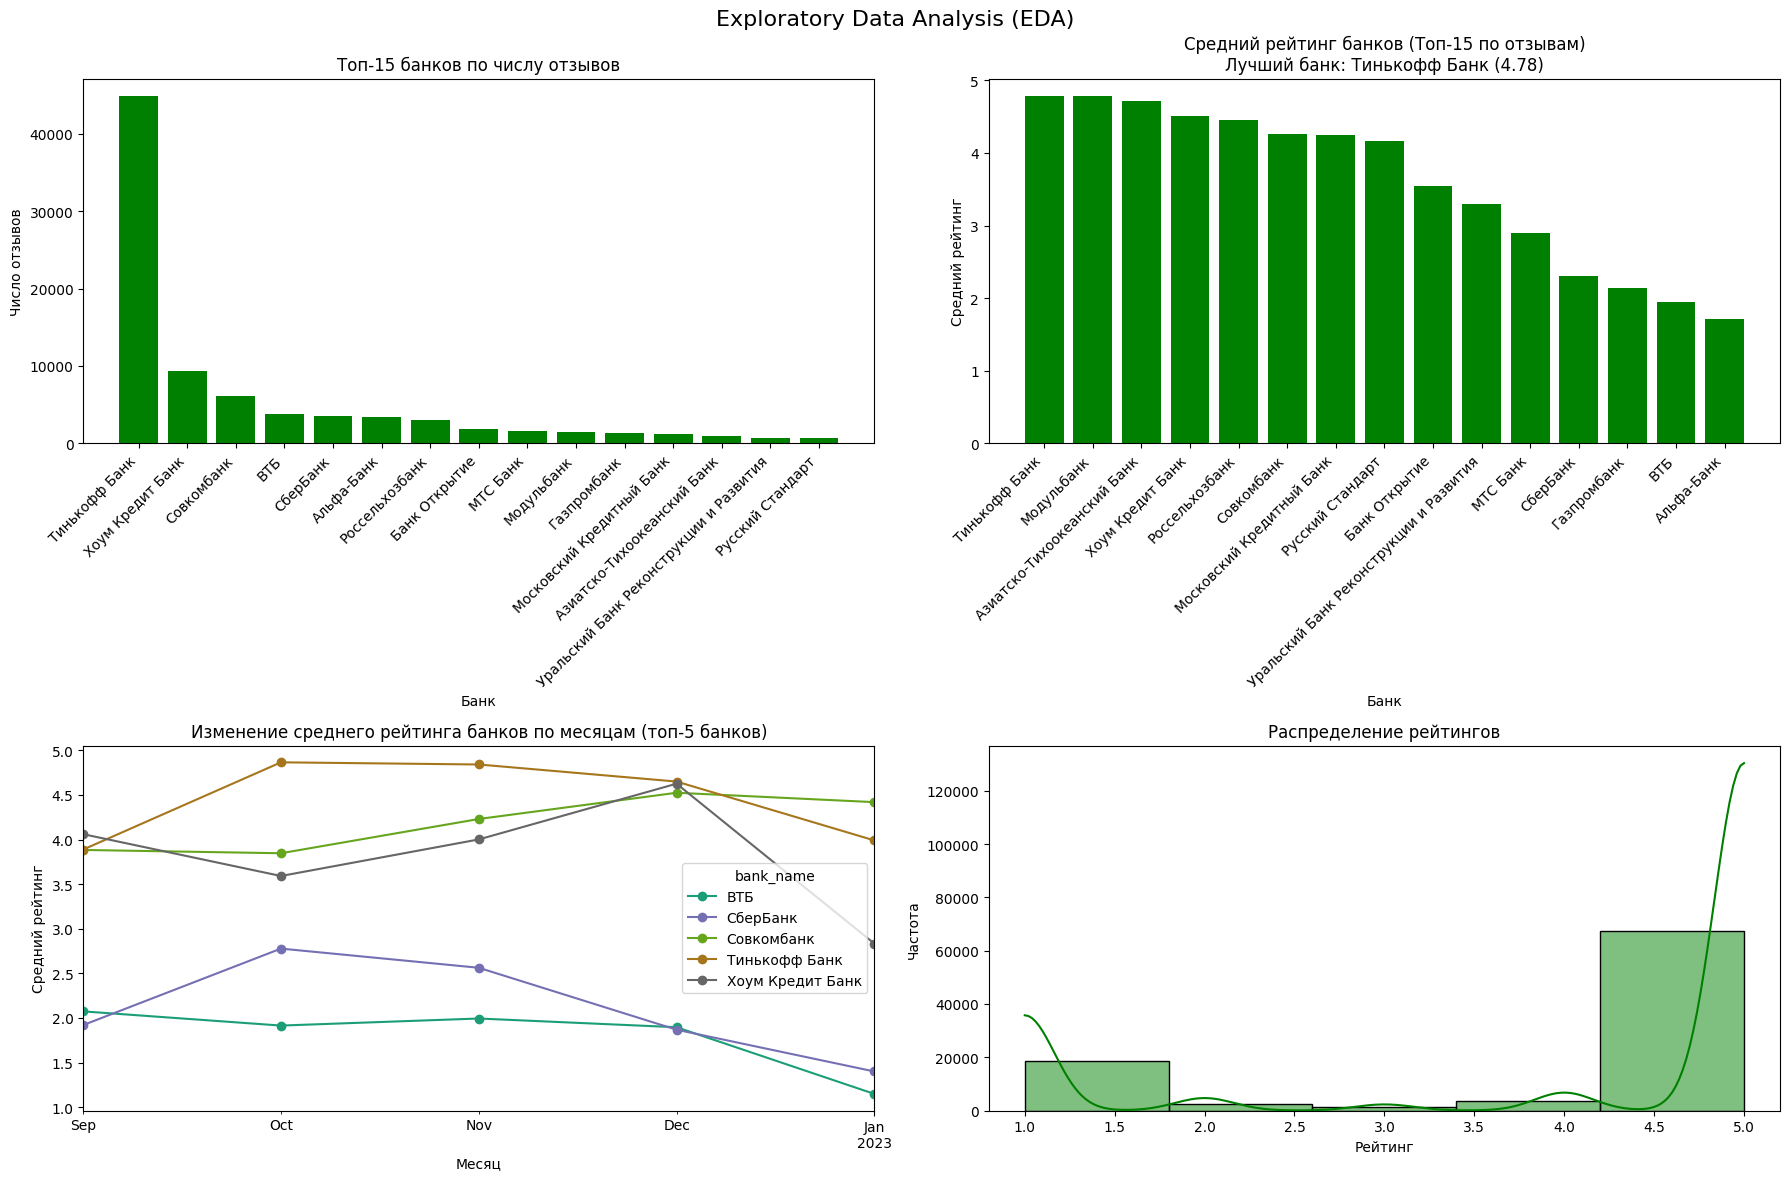

In [10]:
# Преобразуем столбец 'date' в формат datetime
data_preprocessed['date'] = pd.to_datetime(data_preprocessed['date'])

# Создадим subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 12))
fig.suptitle('Exploratory Data Analysis (EDA)', fontsize=16)

# 1. Топ-15 банков по числу отзывов
top_banks = data_preprocessed['bank_name'].value_counts().head(15)
axes[0, 0].bar(top_banks.index, top_banks.values, color='green')
axes[0, 0].set_xticklabels(top_banks.index, rotation=45, ha='right')
axes[0, 0].set_title('Топ-15 банков по числу отзывов')
axes[0, 0].set_xlabel('Банк')
axes[0, 0].set_ylabel('Число отзывов')

# 2. Банк с самым высоким средним рейтингом из топ-15 по числу отзывов
top15_banks_by_reviews = top_banks.index
top15_banks_avg_rating = data_preprocessed[data_preprocessed['bank_name'].isin(top15_banks_by_reviews)].groupby('bank_name')['rating'].mean().sort_values(ascending=False)
best_bank = top15_banks_avg_rating.idxmax()
axes[0, 1].bar(top15_banks_avg_rating.index, top15_banks_avg_rating.values, color='green')
axes[0, 1].set_xticklabels(top15_banks_avg_rating.index, rotation=45, ha='right')
axes[0, 1].set_title(f'Средний рейтинг банков (Топ-15 по отзывам)\nЛучший банк: {best_bank} ({top15_banks_avg_rating.max():.2f})')
axes[0, 1].set_xlabel('Банк')
axes[0, 1].set_ylabel('Средний рейтинг')

# 3. Изменение среднего рейтинга банков по месяцам из топ-5
top5_banks = data_preprocessed['bank_name'].value_counts().head(5).index
data_preprocessed['month'] = data_preprocessed['date'].dt.to_period('M')
top5_banks_avg_rating_sorted = data_preprocessed[data_preprocessed['bank_name'].isin(top5_banks)].groupby(['month', 'bank_name'])['rating'].mean().unstack()
top5_banks_avg_rating_sorted.plot(ax=axes[1, 0], marker='o', colormap='Dark2')
axes[1, 0].set_title('Изменение среднего рейтинга банков по месяцам (топ-5 банков)')
axes[1, 0].set_xlabel('Месяц')
axes[1, 0].set_ylabel('Средний рейтинг')

# 4. Проверка наличия странностей в данных
sns.histplot(data_preprocessed['rating'], bins=5, kde=True, color='green', ax=axes[1, 1])
axes[1, 1].set_title('Распределение рейтингов')
axes[1, 1].set_xlabel('Рейтинг')
axes[1, 1].set_ylabel('Частота')

plt.tight_layout()
plt.show()

#### Выводы

1) **Назвать топ-15 банков по числу отзывов**.

Tinkoff идет с колоссальным отрывом по числу отзывов. В топ-15 банков есть банки, у которых отзывов очень мало.



2) **Какой банк из числа топ-15 по отзывам имеет самый высокий средний рейтинг?**

Со средним рейтингом есть тонкость. Если брать топ-15 банков по количеству отзывов и просто сортировать их по рейтингу, то Тинькофф и Модульбанк наравне занимают топ-1. Однако, у Тинькоффа количество отзывов кратно больше. Соответственно, необходимо сортировать одновременно по рейтингу и количеству отзывов. Модифицируем код и сделаем новый вывод.


3) **Сделать выводы об изменении среднего рейтинга банков по месяцам из топ-5 банков по числу отзывов**

По третьему заданию можно сделать следующие выводы.


    - Тинькофф банк. Потерял первое место среди топ-5 банков по отзывам за декабрь 23 года. Его подвинул с трона Совкомбанк.
    - Хоум Кредит Банк. До декабря 23 года шел почти в ногу с Совкомбанком на рост, но за январь резко упал в рейтинге (с ~4.5 до 3.0)
    - Совкомбанк. Устойчивый рост с сентября по декабрь (включительно) 23 года и по итогу обогнал Тинькофф банк.
    - ВТБ. Немного растет, немного падает - незначительные флуктуации. Это до декабря. За декабрь ВТБ сильно упал и занял последнюю позицию по рейтингу среди топ-5 банков по количеству отзывов.
    - Сбербанк. Хороший рост за сентябрь, затем стабильное падение до начала января. Среди топ-5 банков по количеству отзывов занял предпоследнюю позицию по рейтингу.

    
4) **Странности в данных**
- Дизбаланс в распределении рейтингов (люди почему-то склонны к крайностям - либо "банк отвратительный", либо "шикарный", оценок по середине чудовищно меньше)
- В топ 15 банках по количеству отзывов все еще большая разница по частотам.

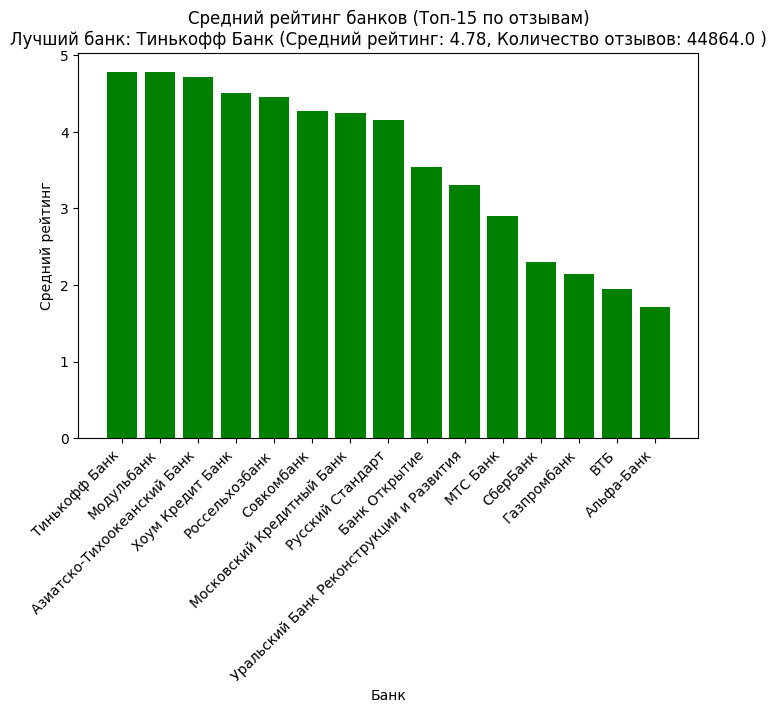

In [11]:
# 2. Банк с самым высоким средним рейтингом из топ-15 по числу отзывов. Сортируем как по рейтингу, так и по количеству отзывов.
top15_banks_by_reviews = top_banks.index
top15_banks_avg_ratingcount = data_preprocessed[data_preprocessed['bank_name'].isin(top15_banks_by_reviews)].groupby('bank_name').agg({'rating': ['mean', 'count']})
top15_banks_avg_ratingcount = top15_banks_avg_ratingcount[top15_banks_avg_ratingcount[('rating', 'count')] >= 10]
top15_banks_avg_ratingcount = top15_banks_avg_ratingcount.sort_values(by=[('rating', 'mean'), ('rating', 'count')], ascending=[False, False])

best_bank = top15_banks_avg_ratingcount.iloc[0]

plt.figure(figsize=(8, 5))
plt.bar(top15_banks_avg_ratingcount.index, top15_banks_avg_ratingcount[('rating', 'mean')], color='green')
plt.xticks(rotation=45, ha='right')
plt.title(f'Средний рейтинг банков (Топ-15 по отзывам)\nЛучший банк: {best_bank.name} (Средний рейтинг: {best_bank[("rating", "mean")]:.2f}, Количество отзывов: {best_bank[("rating", "count")]} )')
plt.xlabel('Банк')
plt.ylabel('Средний рейтинг')
plt.show()

In [12]:
display(top15_banks_avg_rating)

bank_name
Тинькофф Банк                              4.783568
Модульбанк                                 4.780137
Азиатско-Тихоокеанский Банк                4.718282
Хоум Кредит Банк                           4.505585
Россельхозбанк                             4.455940
Совкомбанк                                 4.264768
Московский Кредитный Банк                  4.241407
Русский Стандарт                           4.158200
Банк Открытие                              3.543295
Уральский Банк Реконструкции и Развития    3.298128
МТС Банк                                   2.901427
СберБанк                                   2.303725
Газпромбанк                                2.145358
ВТБ                                        1.950223
Альфа-Банк                                 1.714159
Name: rating, dtype: float64

In [13]:
display(top15_banks_avg_ratingcount)

rating       
                                             mean  count
bank_name                                               
Тинькофф Банк                            4.783568  44864
Модульбанк                               4.780137   1460
Азиатско-Тихоокеанский Банк              4.718282   1001
Хоум Кредит Банк                         4.505585   9310
Россельхозбанк                           4.455940   3064
Совкомбанк                               4.264768   6111
Московский Кредитный Банк                4.241407   1251
Русский Стандарт                         4.158200    689
Банк Открытие                            3.543295   1894
Уральский Банк Реконструкции и Развития  3.298128    748
МТС Банк                                 2.901427   1542
СберБанк                                 2.303725   3490
Газпромбанк                              2.145358   1314
ВТБ                                      1.950223   3817
Альфа-Банк                               1.714159   3369

#### Вывод
На самом деле, что сортировать по рейтингу, что по рейтингу и количеству отзывов: как оказалось, разницы нет. Что в первом случае, что во втором Тинькофф перевешивал за счет разницы в тысячных и огромной массы отзывов. Однако, я считаю, эту сортировку все же нужно проводить именно по двум показателям (рейтинг и количество отзывов), ибо могут быть ситуации, где другое решение исказит рейтинг.

### Дополнительный EDA

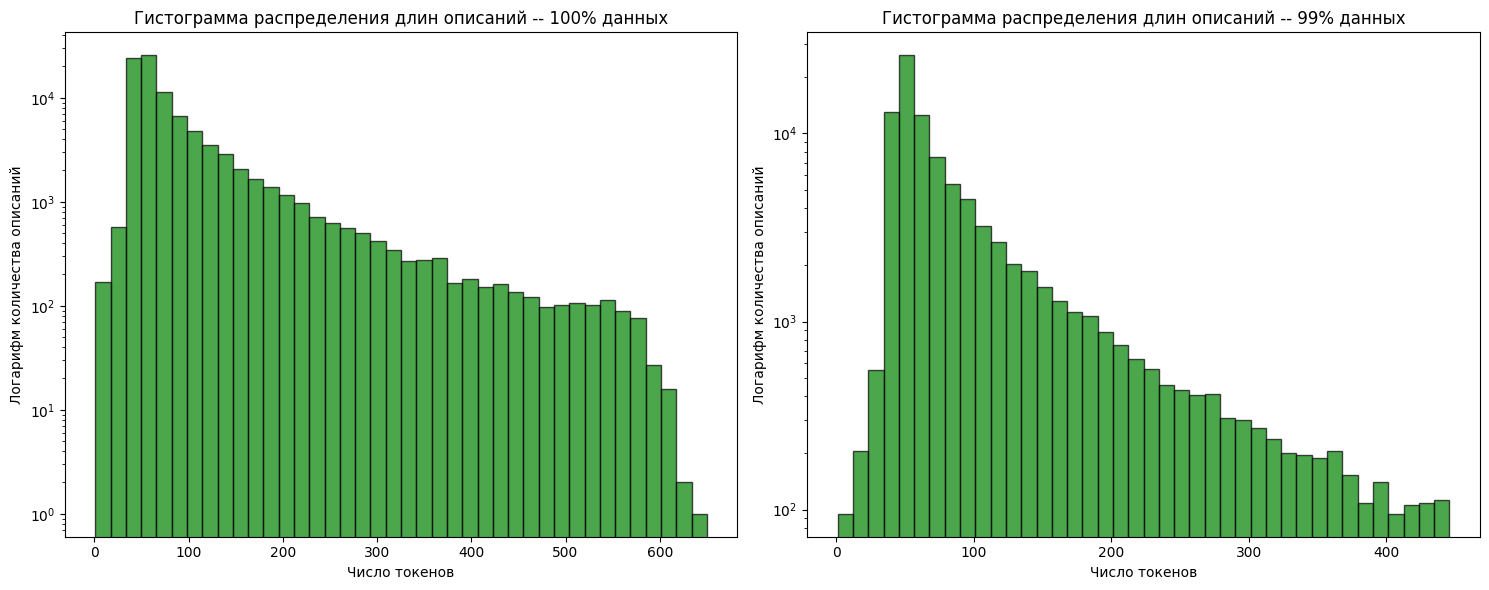

In [14]:
desc_lengths = np.array([len(desc.split()) for desc in data["body"]])

# Гистограмма для 100% данных
max_length_limit = np.percentile(desc_lengths, 100)
filtered_desc_lengths = desc_lengths[desc_lengths <= max_length_limit]

plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.hist(filtered_desc_lengths, bins=40, color='green', alpha=0.7, edgecolor='black', log=True)
plt.title('Гистограмма распределения длин описаний -- 100% данных')
plt.xlabel('Число токенов')
plt.ylabel('Логарифм количества описаний')

# Гистограмма для 99% данных
max_length_limit = np.percentile(desc_lengths, 99)
filtered_desc_lengths = desc_lengths[desc_lengths <= max_length_limit]

plt.subplot(1, 2, 2)
plt.hist(filtered_desc_lengths, bins=40, color='green', alpha=0.7, edgecolor='black', log=True)
plt.title('Гистограмма распределения длин описаний -- 99% данных')
plt.xlabel('Число токенов')
plt.ylabel('Логарифм количества описаний')

plt.tight_layout()
plt.show()

#### Вывод
Если принять 1% самых высоких значений за выбросы, мы сильно облегачаем себе задачу -- вместо того чтобы работать с последовательностями длиной 600 токенов, имеем дело лишь с ~400

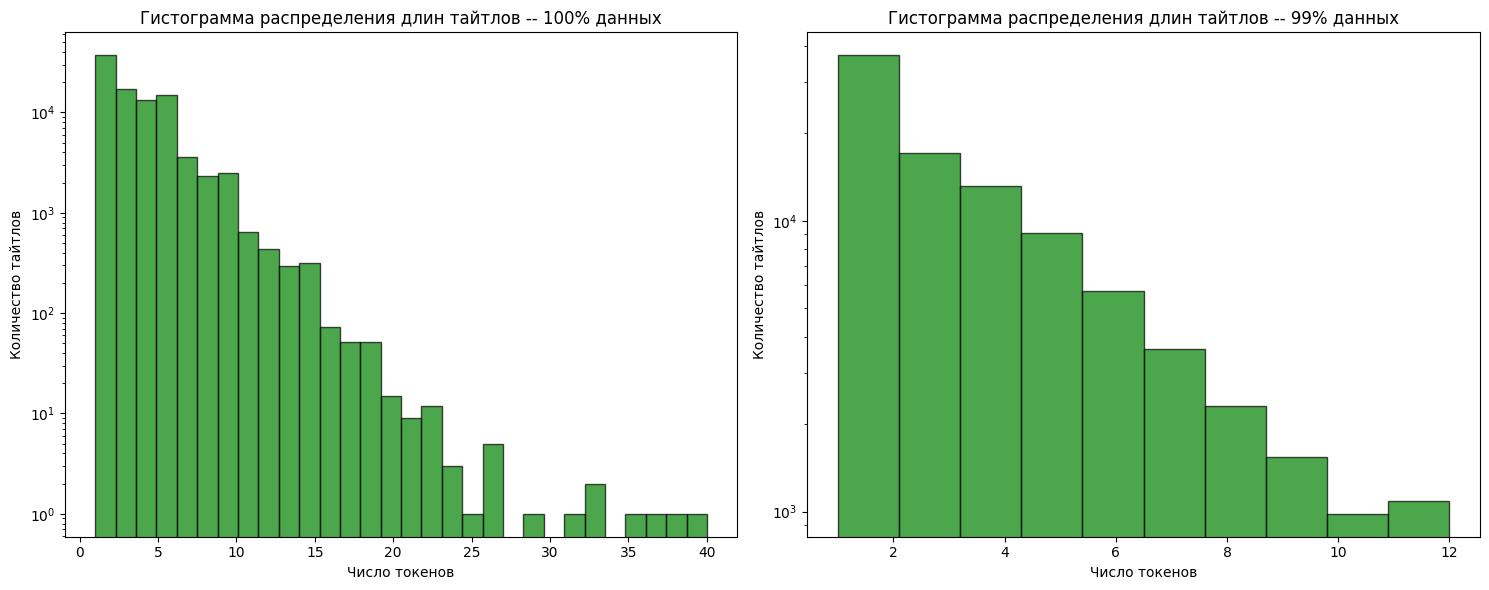

In [15]:
# Преобразование заголовков в список длин
title_lengths = np.array([len(title.split()) for title in data["title"]])

# Гистограмма для 100% данных заголовков
max_tlength_limit = np.percentile(title_lengths, 100)
filtered_titles_lengths = title_lengths[title_lengths <= max_tlength_limit]

plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.hist(filtered_titles_lengths, bins=30, alpha=0.7, color='green', edgecolor='black', log=True)
plt.title('Гистограмма распределения длин тайтлов -- 100% данных')
plt.xlabel('Число токенов')
plt.ylabel('Количество тайтлов')

# Гистограмма для 99% данных заголовков
max_tlength_limit = np.percentile(title_lengths, 99)
filtered_titles_lengths = title_lengths[title_lengths <= max_tlength_limit]

plt.subplot(1, 2, 2)
plt.hist(filtered_titles_lengths, bins=10, alpha=0.7, color='green', edgecolor='black', log=True)
plt.title('Гистограмма распределения длин тайтлов -- 99% данных')
plt.xlabel('Число токенов')
plt.ylabel('Количество тайтлов')

plt.tight_layout()
plt.show()

#### Вывод
Идентичная ситуация с заголовками. Исключим выбросы - упростим вычислительную сложность моделей, которые мы будем строить

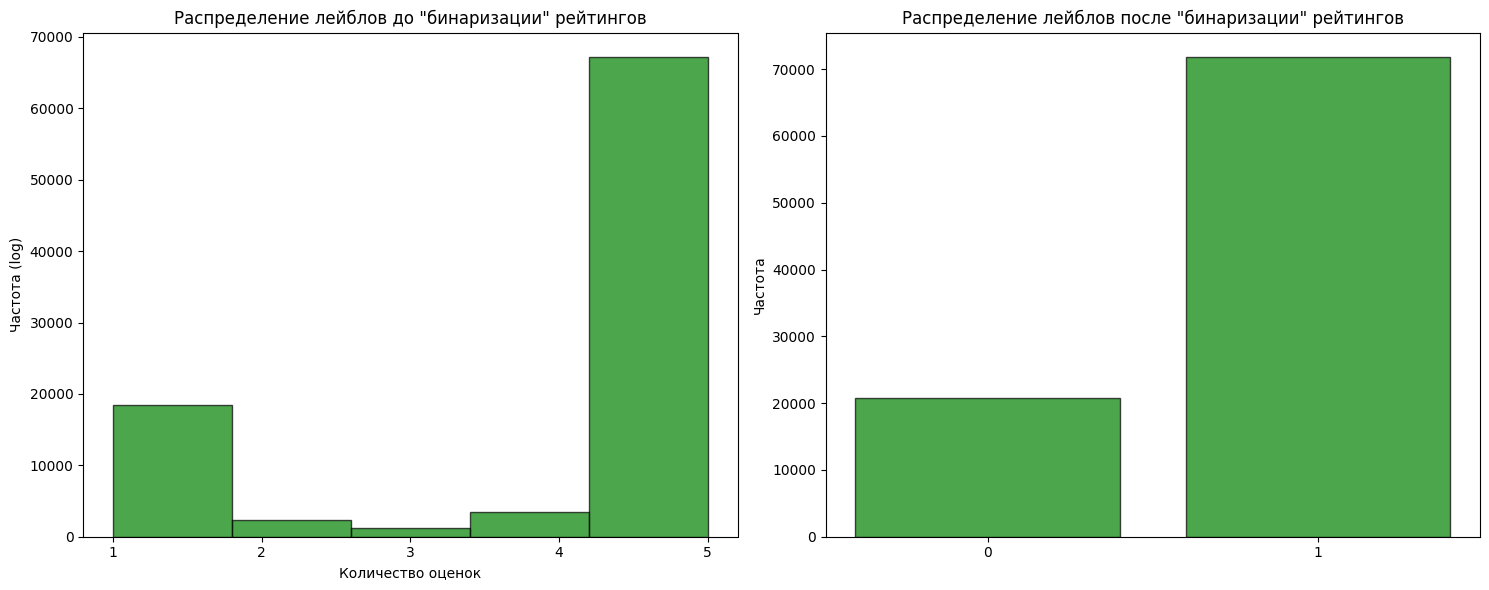

In [16]:
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.hist(data_preprocessed['rating'], bins=5, edgecolor='black', color='green', alpha=0.7, log=False)
plt.title('Распределение лейблов до "бинаризации" рейтингов')
plt.ylabel('Частота (log)')
plt.xlabel('Количество оценок')
plt.xticks([1, 2, 3, 4, 5])

data_preprocessed['rating'] = data_preprocessed['rating'].apply(lambda x: 1 if x >= 3 else 0)

plt.subplot(1, 2, 2)
unique_values, counts = data_preprocessed['rating'].value_counts().sort_index().index, data_preprocessed['rating'].value_counts().sort_index().values
plt.bar(unique_values, counts, edgecolor='black', color='green', alpha=0.7, log=False)
plt.title('Распределение лейблов после "бинаризации" рейтингов')
plt.ylabel('Частота')
plt.xticks([0, 1])

plt.tight_layout()
plt.show()

In [17]:
disbalance = counts[1] / sum(counts) * 100
print(round(disbalance), '% от всех сэмплов составляют положительные отзывы.')

78 % от всех сэмплов составляют положительные отзывы.


#### Вывод
Имеем приличный дизбаланс классов. Это чревато проблемами с перфомансом моделей. Пока что построим подходы на данных с дизбалансом. В теории, можно использовать андер- или овер-семплинг техники (ex. SMOTE from imblearn) для борьбы с ним.

## Модели классификации

Я построю две незамысловатые модели (Наивный Байес и Логистическая регрессия), а также Сверточную и Реккурентную нейросети. Самые простые подходы будут рассмотрены в контрасте с самыми сложными (не считая трансформеров, под такую задачу было бы совсем жирно их здесь использовать, ибо, как мы увидим, даже простые модели дают очень серьезный скор ROC-AUC)

### От простого к сложному. Наивный Байес.

#### Bag of Words

In [18]:
# Для удобства объединю заголовок и текст отзыва
data_preprocessed['merged_text'] = data_preprocessed['title'] + '; ' + data_preprocessed['body']

# Выводим первые несколько строк нового столбца
print(data_preprocessed['merged_text'].head())

0    заблокировали средства; добрый день пишу сюда ...
1    возврат просроченной задолженномти; при возвра...
2    ошибочное начисление комиссии , затягивание пр...
3    клиентоориентиванность 10 из 10; новый год нач...
4    как газпромбанк обманывает клиентов с акционны...
Name: merged_text, dtype: object


In [19]:
texts = data_preprocessed['merged_text'].values
target = data_preprocessed['rating'].values
texts[0], target[0]

('заблокировали средства; добрый день пишу сюда для более скорого разрешения вопроса пополнил через юмани озон банк после чего вывести деньги не дал , сославшись на сомнительные операции ( понимаю , могло так показаться ) просто озон удобен тем что можно пополнить его через qiwi и юмани без комиссии , за что ценю документы предоставил , причины переводов тоже надеюсь на разблокировку , если не для переводов , то хотя бы для оплаты товаров для привлечения внимания пока ставлю 1 после решения вопроса поставлю 5',
 0)

In [20]:
from sklearn.model_selection import train_test_split

texts_train, texts_test, y_train, y_test = train_test_split(texts, target, test_size=0.2, random_state=42)

In [29]:
from collections import Counter

tokens_list = [text.split() for text in texts_train]
total_train_tokens = [word for sublist in tokens_list for word in sublist]

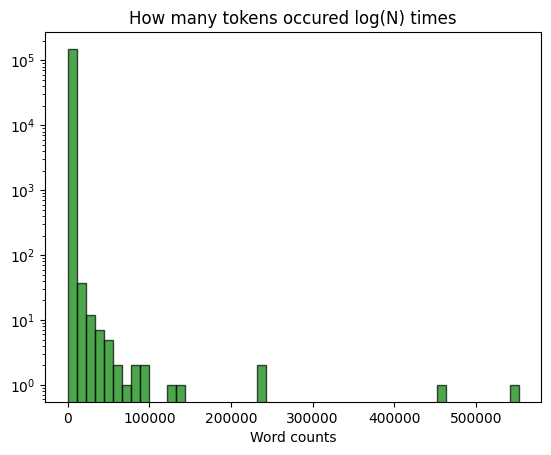

In [30]:
word_counts = [count for word, count in Counter(total_train_tokens).most_common()]

plt.hist(word_counts, bins=50, color='green', alpha=0.7, edgecolor='black', log=True)
plt.xlabel("Word counts")
plt.title('How many tokens occured log(N) times')
plt.show()

##### Вывод
Картина, которую мы наблюдаем называется "Закон Ципфа". Токенов, которые встречаются минимально очень много. Это распределение по своим своим свойствам похоже на экспоненциальное. То, что встречается мало раз не несет особого смысла. Поставим фильтр на встречаемость токенов для включения в словарь.

In [31]:
token_counts = Counter(total_train_tokens)
unique_tokens = sorted([t for t, c in token_counts.items() if c >= 100], reverse=True) # Частота 100, для облегчения вычислений

Создам словарь для bag of words. Добавлю в него токены UNK и PAD.

In [32]:
bow_vocabulary, top_counts = zip(*Counter(unique_tokens).most_common())
bow_vocabulary, top_counts = list(bow_vocabulary), list(top_counts)

UNK, PAD = "UNK", "PAD"
bow_vocabulary = [UNK, PAD] + bow_vocabulary

In [33]:
print(f'Мы убрали токены, которые встречались реже, чем 100 раз. \nДлина словаря: {len(bow_vocabulary)} токенов')

Мы убрали токены, которые встречались реже, чем 100 раз. 
Длина словаря: 5728 токенов


In [34]:
print('example features:', sorted(bow_vocabulary)[::500])

example features: ['!', 'быстрота', 'грубо', 'зарегистрировать', 'кредита', 'наша', 'осуществлять', 'подсказала', 'приемлемые', 'решится', 'сроки', 'финансовая']


Создам словари token_to_id и id_to_token

In [35]:
token_to_id = {}
for w in bow_vocabulary:
  token_to_id[w] = bow_vocabulary.index(w)

id_to_token = {id: word for word, id in token_to_id.items()}

Функция для токенизации текста и функция для приведения текста обратно в человеческий вид.

In [43]:
def tokenize_text(text, token_to_id):
    nested_s_list = text.split()
    tokenized_s_list = [token_to_id[w] if w in token_to_id else token_to_id['UNK'] for w in nested_s_list]
    return tokenized_s_list

def untokenize(tokenized_text_id, texts_array, id_to_token):
  tokens = [id_to_token[id] for id in texts_array[tokenized_text_id]]
  orginal_text = ' '.join(tokens)
  print(f'Tokenized text: \n\n{texts_array[tokenized_text_id]}')
  print(f'\nOriginal text: \n\n{orginal_text}')

tokenized_texts_train = [tokenize_text(text, token_to_id) for text in texts_train]
tokenized_texts_test = [tokenize_text(text, token_to_id) for text in texts_test]

In [29]:
untokenize(0, tokenized_texts_train, id_to_token)

Tokenized text: 

[2683, 2982, 5219, 2567, 3074, 5683, 825, 4960, 2058, 5683, 2973, 4138, 3973, 235, 4138, 3973, 28, 3618, 5683, 5361, 1648, 4875, 4628, 735, 2336, 0, 5683, 4716, 3692, 634, 5361, 4319, 5683, 2058, 1377, 103, 3447, 1720, 5683, 2532, 3135, 5683, 3541, 5600, 3472, 2877, 5679, 0, 4138, 0, 3135, 5683, 364, 4734, 1429]

Original text: 

отзыв; обслуживание в офисе нравится , сотрудники всегда помогают , обслуживаюсь и как физическое и как юридическое лицо , без проблем выдают денежные средства по UNK , даже крупные суммы без заказа , помогают разобраться через мобильное приложение , очередей нет , максимум 3 минуты ожидания . UNK и UNK нет , удобный график работы


Функция, приводящая все последовательности к одной длине к одной длинне с помощью padding & truncation. Технически, можно использовать и с classic ML подходами, но это лишь усложнит процесс вычислений. Это заготовка для нейросетей.

In [30]:
def process_sentences(tokenized_sentences, max_len, token_to_id):
    """
    Корректирует длину токенизированных предложений в заданном списке токенизированных предложений.

    :param tokenized_sentences: Список списков, где каждый внутренний список - токенизированное предложение.
    :param max_len: Максимальная длина предложения.
    :param token_to_id: Словарь, отображающий токены в их уникальные идентификаторы, содержащий ключи 'UNK' и 'PAD'.
    :return: Массив NumPy, где каждая строка - токенизированное предложение одинаковой длины.
    """

    processed_sentences = []

    for sentence in tokenized_sentences:
        # Если предложение слишком длинное, усекаем его
        if len(sentence) > max_len:
            sentence = sentence[:max_len]
        # Если предложение слишком короткое, дополняем его
        elif len(sentence) < max_len:
            sentence += [token_to_id['PAD']] * (max_len - len(sentence))

        processed_sentences.append(sentence)

    # return np.array(processed_sentences)
    return processed_sentences


pt_texts_train = process_sentences(tokenized_texts_train, 500, token_to_id) # Длина 500 выбрана на основе распределений длин заголовков и описаний
pt_texts_test = process_sentences(tokenized_texts_test, 500, token_to_id)

In [31]:
def text_to_bow(text, token_to_id=token_to_id):
    """Преобразовывает текстовую последовательность в массив BOW, используя словарь (token_to_id)."""

    bow_vector = np.zeros(len(token_to_id), dtype='float32')
    for word in text.split():
        if word in token_to_id:
            bow_vector[token_to_id[word]] += 1
    return bow_vector

X_train_bow = np.stack(list(map(text_to_bow, texts_train)))
X_test_bow = np.stack(list(map(text_to_bow, texts_test)))

Наивный Байес

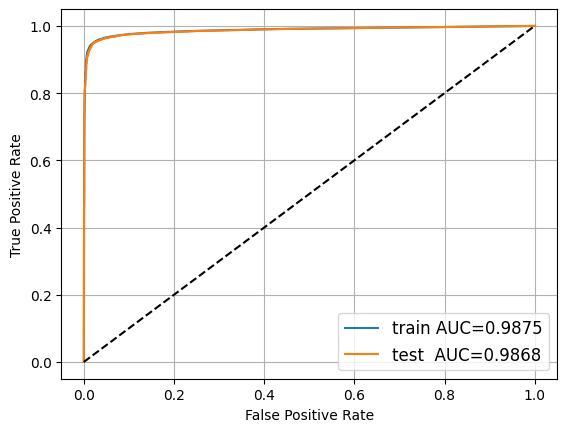

In [32]:
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.naive_bayes import MultinomialNB

naive_model_sklearn = MultinomialNB().fit(X_train_bow, y_train)

for name, X, y, model in [
    ('train', X_train_bow, y_train, naive_model_sklearn),
    ('test ', X_test_bow, y_test, naive_model_sklearn)
]:
    proba = model.predict_proba(X)[:, 1] - model.predict_proba(X)[:, 0]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(fontsize='large')
plt.grid()
plt.show()

Чтобы понять, что выучила модель, найдем топ-25 слов, у которых наибольшее отношение вероятности положительного класса к отрицательному ${p(x_i | y=1)} \over {p(x_i | y=0)}$ и наоборот, ${p(x_i | y=0)} \over {p(x_i | y=1)}$.

In [33]:
log_probabilities = naive_model_sklearn.feature_log_prob_
# Calculate the ratio of probabilities for each feature
prob_ratio = np.exp(log_probabilities[1] - log_probabilities[0])

feature_names = np.array(list(token_to_id.keys()))
word_ratios_df = pd.DataFrame({'word': feature_names, 'ratio': prob_ratio})
word_ratios_df = word_ratios_df.sort_values(by='ratio', ascending=False)
top_25_words = word_ratios_df.head(25)

top_25_words

,word,ratio
5317,благодарность;,1195.451581
2677,отзывчивая,663.175095
2675,отзывчивые,571.679639
4833,выручает,443.452430
2676,отзывчивость,341.939223
2839,оперативная,331.253622
819,сотруднику;,257.122267
4570,доброжелательные,240.426016
2335,поблагодарить,239.491026
5227,быстрые,215.047715


In [34]:
prob_ratio_inverse = np.exp(log_probabilities[0] - log_probabilities[1])
word_ratios_inverse_df = pd.DataFrame({'word': feature_names, 'ratio_inverse': prob_ratio_inverse})
word_ratios_inverse_df = word_ratios_inverse_df.sort_values(by='ratio_inverse', ascending=False)
top_25_words_inverse = word_ratios_inverse_df.head(25)

top_25_words_inverse

,word,ratio_inverse
1100,связывайтесь,288.987028
3034,обманщики,117.541356
1564,прокуратуру,103.690942
2702,отвратительное,91.088312
4794,гк,84.849387
2701,отвратительный,60.941824
5337,беспредел,59.893685
3298,нарушает,52.406974
387,удерживает,49.412290
3181,некомпетентность,49.225122


Вывод: модель точно определила слова, которые характерны для явно негативных (обманщики, отврататительно, бардак, etc.) и позитивных отзывов (благодарность, отзывчивость, выручать). В виду своих допущений, которые обеспечивают Наивному Байесу его простоту, он не улавливает более глубоких связей.

### Чуть сложнее. Logistic Regression

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


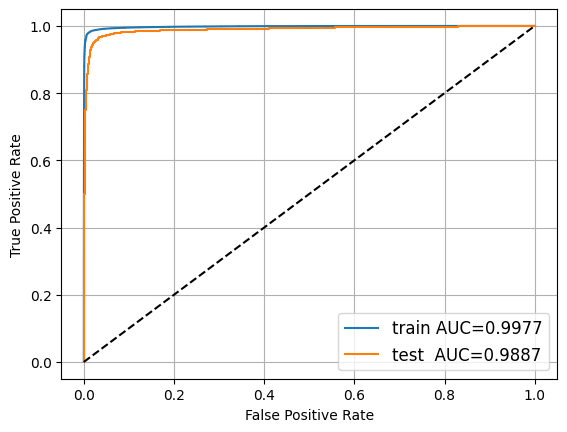

In [35]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression().fit(X_train_bow, y_train)

for name, X, y, model in [
    ('train', X_train_bow, y_train, lr),
    ('test ', X_test_bow, y_test, lr)
]:
    proba = model.predict_proba(X)[:, 1] - model.predict_proba(X)[:, 0]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(fontsize='large')
plt.grid()
plt.show()

In [45]:
tokenized_texts_train = [' '.join(map(str, text)) for text in tokenized_texts_train]
tokenized_texts_test = [' '.join(map(str, text)) for text in tokenized_texts_test]

In [47]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize

vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(tokenized_texts_train)
X_test_tfidf = vectorizer.transform(tokenized_texts_test)

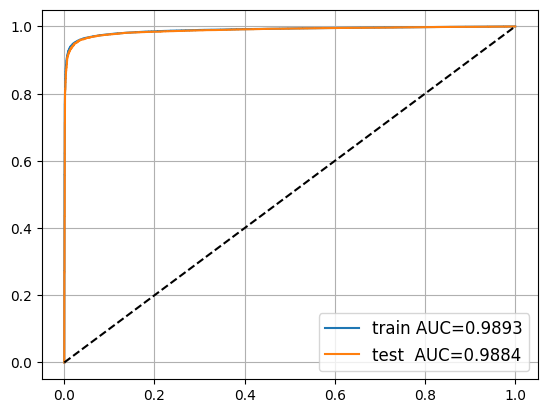

In [51]:
naive_model = MultinomialNB().fit(X_train_tfidf, y_train)

for name, X, y, model in [
    ('train', X_train_tfidf, y_train, naive_model),
    ('test ', X_test_tfidf, y_test, naive_model)
]:
    proba = model.predict_proba(X)[:, 1] - model.predict_proba(X)[:, 0]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()
plt.show()

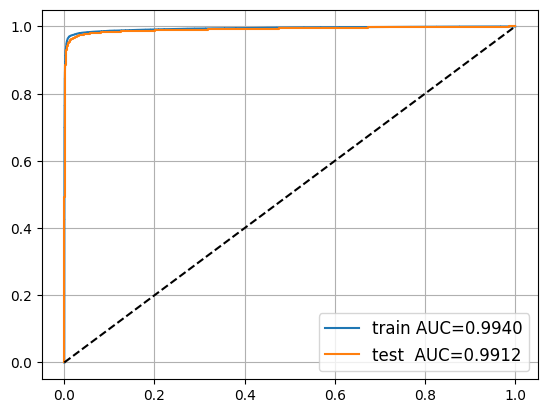

In [52]:
lr = LogisticRegression().fit(X_train_tfidf, y_train)

for name, X, y, model in [
    ('train', X_train_tfidf, y_train, lr),
    ('test ', X_test_tfidf, y_test, lr)
]:
    proba = model.predict_proba(X)[:, 1] - model.predict_proba(X)[:, 0]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

Интерпретируем результаты Логистической регрессии.

In [54]:
import shap

explainer = shap.LinearExplainer(lr, X_train_tfidf)

# Получение значений Шэпли для тестового набора данных
shap_values = explainer.shap_values(X_test_tfidf)

In [ ]:
feature_names_indices = vectorizer.get_feature_names_out()
feature_names_words = [id_to_token[int(idx)] for idx in feature_names_indices]

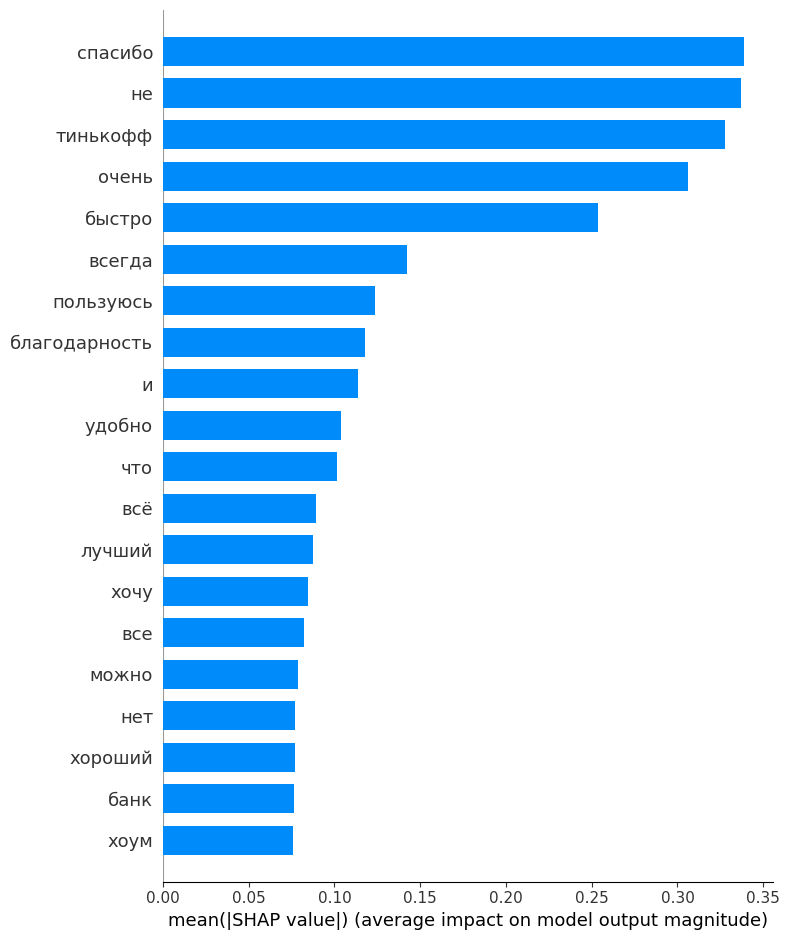

In [99]:
shap.summary_plot(shap_values, features=X_test_tfidf, feature_names=feature_names_words, plot_type='bar', max_display=20)

Заметны положительные по окраске слова, но, в целом, не выходит как в Наивном Байесе явно увидеть слова характерные классу 0 и классу 1. Возможно, модель выигрывает на уровне относительных пропорций весов между собой, нежели только берет какой-то "красный" или "зеленый" флаг в виде ярко окрашенного слова и делает предсказание на нем.

Также визуализируем, как формировалось предсказание на несколько единичных сэмплов

In [75]:
X_test_tfidf_df = pd.DataFrame(X_test_tfidf.toarray(), columns=feature_names_words) # для удобства

Пример негативного отзыва. Фича-слово "обман" сильно толкнуло предсказание к классу 0.

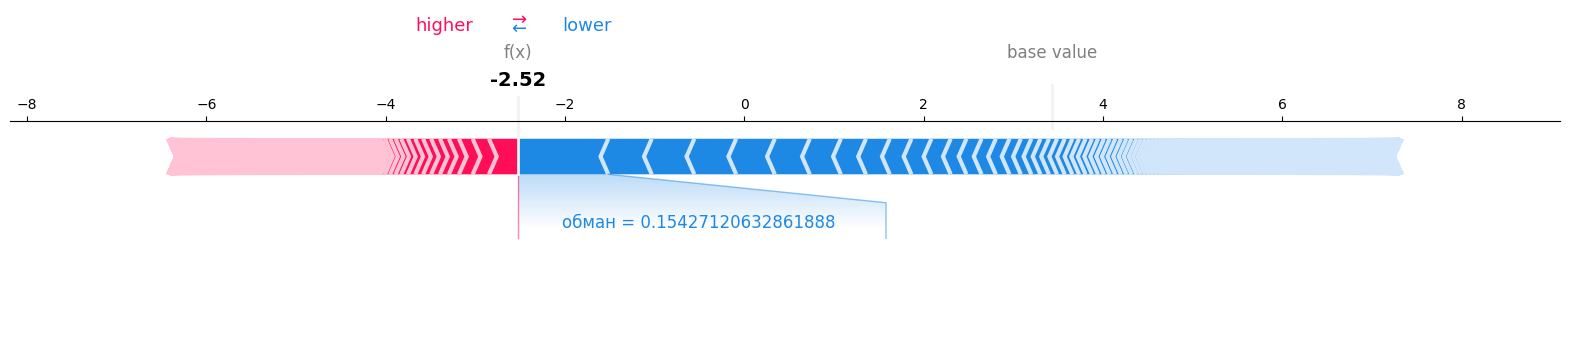

In [94]:
shap.force_plot(explainer.expected_value, shap_values[7, :], X_test_tfidf_df.iloc[7, :], matplotlib=True, feature_names=feature_names_words)

Пример позитивного отзыва. Видно, как позитивно окрашенные слова толкают логит к классу 1.

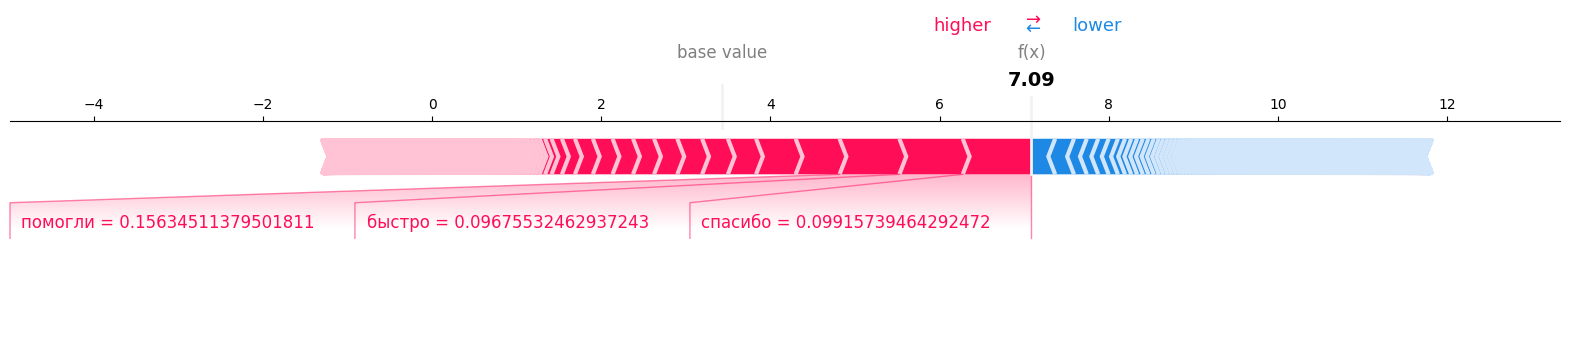

In [96]:
shap.force_plot(explainer.expected_value, shap_values[800, :], X_test_tfidf_df.iloc[800, :], matplotlib=True, feature_names=feature_names_words)

Любопытная закономерность. Как мы видели, Тинькофф имеет огромное количество положительных отзывов. По этой причине, фича-слово Тинькофф сильно смещает предсказание к положительному классу.

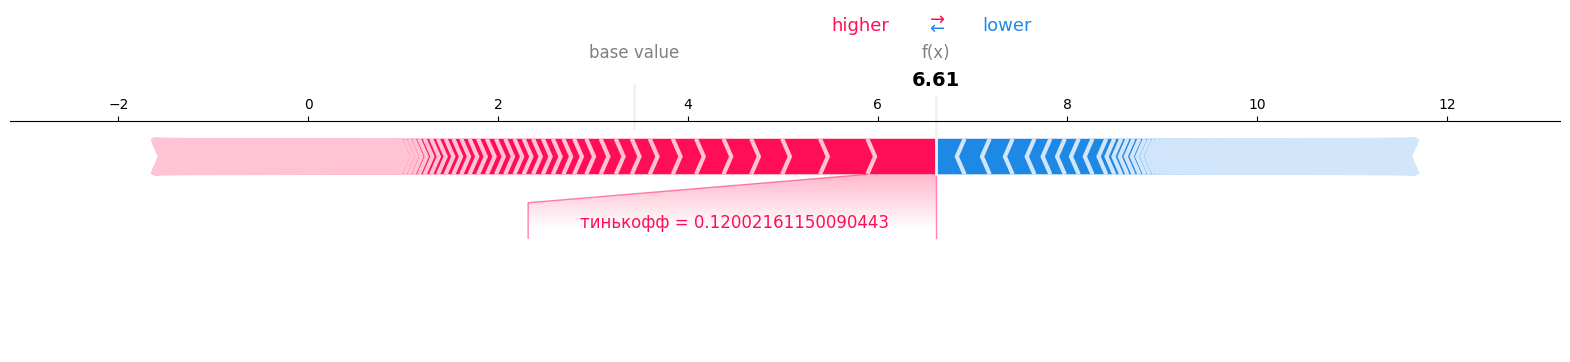

In [78]:
shap.force_plot(explainer.expected_value, shap_values[2, :], X_test_tfidf_df.iloc[2, :], matplotlib=True, feature_names=feature_names_words)

### Word Vectors. Solving it better (perhaps)

Вместо подсчета частот для каждого слова мы попробуем другой подход: отобразим все слова на предобученные векторы слов и усредним их, чтобы получить признаки текста.

Скачанные ниже эмбэддинги хранятся по ключам в виде "хлеб_NOUN". Поэтому, нам нужно лемматизировать тексты и дописать к ним их часть речи.

In [103]:
import gensim.downloader
embeddings = gensim.downloader.load("word2vec-ruscorpora-300")

[==================================================] 100.0% 198.8/198.8MB downloaded


In [104]:
import spacy

# Download the pre-trained spaCy model for Russian
!python -m spacy download ru_core_news_sm
nlp = spacy.load("ru_core_news_sm")

Looking in indexes: https://pypi.org/simple, https://packagecloud.io/github/git-lfs/pypi/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 2.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.2/53.2 KB 551.0 kB/s eta 0:00:00 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 2.2 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('ru_core_news_sm')


In [ ]:
# from tqdm import tqdm

# lemmatized_train_texts = []
# lemmatized_test_texts = []

# #Лемматизируем и добавляем _часть речи к токенам
# for text in tqdm(texts_train):
#     lemmatized_text = [f"{token.lemma_}_{token.pos_}" for token in nlp(text)]
#     lemmatized_train_texts.append(lemmatized_text)

# for text in tqdm(texts_test):
#     lemmatized_text = [f"{token.lemma_}_{token.pos_}" for token in nlp(text)]
#     lemmatized_test_texts.append(lemmatized_text)

100%|██████████| 18547/18547 [18:27<00:00, 16.75it/s]


Лемматизация заняла много времени, поэтому я сохранил ее результат. Загрузим тексты из файлов.

In [106]:
# Load 'em.

with open('data/lemmatized_train_texts.pkl', 'rb') as f:
    lemmatized_train_texts = pickle.load(f)

with open('data/lemmatized_test_texts.pkl', 'rb') as f:
    lemmatized_test_texts = pickle.load(f)

In [107]:
def vectorize_sum(comment, embeddings=embeddings):
    """
    Convert preprocessed comment to the sum of token vectors after lemmatization
    """
    embedding_dim = embeddings.vectors.shape[1]
    features = np.zeros([embedding_dim], dtype='float32')

    for word in comment:
        if word in embeddings.key_to_index:
            features += embeddings.get_vector(word)

    # Normalize the sum of word vectors by the square root of the number of tokens
    features /= np.sqrt(len(comment))

    return features

X_train_wv = np.stack([vectorize_sum(text) for text in lemmatized_train_texts])
X_test_wv = np.stack([vectorize_sum(text) for text in lemmatized_test_texts])

#### LogReg on WV | Test ROC-AUC: 0.9873

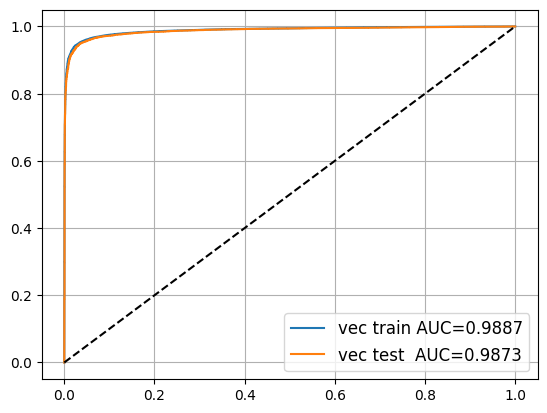

In [108]:
lr_wv = LogisticRegression(max_iter=1000).fit(X_train_wv, y_train)

for name, X, y, model in [
    ('vec train', X_train_wv, y_train, lr_wv),
    ('vec test ', X_test_wv, y_test, lr_wv)
]:
    proba = model.predict_proba(X)[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

При суммировании векторов отдельных слов, высокочастотные слова "перетягивают на себя одеяло". Попробуем раздать веса векторам по убыванию по их частотности. У нас нет непосредственно частот, но в словаре эмбэддингов слова перечислены по убыванию по встречаемости. Используем это знание на практике.

In [110]:
def rank_to_weight(rank, total_words):
    return np.log(rank + 1) / np.log(total_words)

word_ranks = {word: rank + 1 for rank, word in enumerate(embeddings.index_to_key)}

def vectorize_sum(comment, embeddings=embeddings, word_ranks=None):
    """
    Convert preprocessed comment to the sum of token vectors after lemmatization
    with additional features for word ranking and weighting.
    """
    embedding_dim = embeddings.vectors.shape[1]
    features = np.zeros([embedding_dim], dtype='float32')

    if word_ranks is None:
        raise ValueError("word_ranks must be provided.")
    total_words = len(embeddings.index_to_key)

    for word in comment:
        if word in embeddings.key_to_index:
            features += embeddings.get_vector(word) * rank_to_weight(word_ranks.get(word, 0), total_words)

    # Normalize the sum of word vectors by the square root of the number of tokens
    features /= np.sqrt(len(comment))

    return features

X_train_wv_smarter = np.stack([vectorize_sum(text, word_ranks=word_ranks) for text in lemmatized_train_texts])
X_test_wv_smarter = np.stack([vectorize_sum(text, word_ranks=word_ranks) for text in lemmatized_test_texts])

#### LogReg on smarter WV | Test ROC-AUC: 0.9865

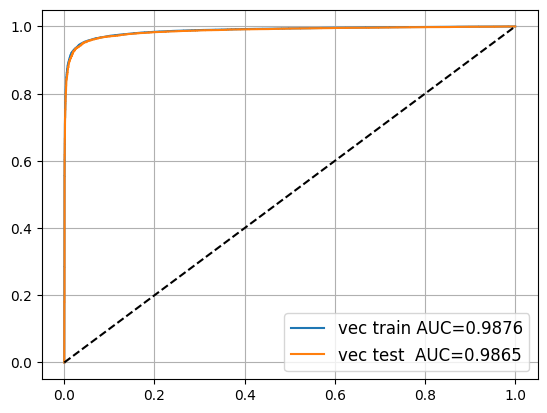

In [111]:
lr_wv_smarter = LogisticRegression(max_iter=1000).fit(X_train_wv_smarter, y_train)

for name, X, y, model in [
    ('vec train', X_train_wv_smarter, y_train, lr_wv_smarter),
    ('vec test ', X_test_wv_smarter, y_test, lr_wv_smarter)
]:
    proba = model.predict_proba(X)[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

Не выстрелило. Возможно, стоило считать веса линейно или как-то иначе.

### Neural approach

In [112]:
lemmatized_train_texts[0][:5]

['отзыв_NOUN', ';_PUNCT', 'обслуживание_NOUN', 'в_ADP', 'офис_NOUN']

In [ ]:
from collections import Counter

tokens_list = [text for text in lemmatized_train_texts]
total_train_tokens = [word for sublist in tokens_list for word in sublist]

token_counts = Counter(total_train_tokens)
unique_tokens = sorted([t for t, c in token_counts.items() if c >= 2], reverse=True) # Частота 100, для облегчения вычислений

nn_vocabulary, top_counts = zip(*Counter(unique_tokens).most_common())
nn_vocabulary, top_counts = list(nn_vocabulary), list(top_counts)

UNK, PAD = "UNK", "PAD"
nn_vocabulary = [UNK, PAD] + nn_vocabulary

token_to_id_nn = {}
for w in nn_vocabulary:
  token_to_id_nn[w] = nn_vocabulary.index(w)

id_to_token_nn = {id: word for word, id in token_to_id_nn.items()}

print(f'Vocabulary size: {len(id_to_token_nn)} tokens')

Vocabulary size: 41237 tokens


In [ ]:
def tokenize_text(text):
    tokenized_s_list = [token_to_id_nn[w] if w in token_to_id_nn else token_to_id_nn['UNK'] for w in text]
    return tokenized_s_list

def untokenize(tokenized_text_id, texts_array):
  tokens = [id_to_token_nn[id] for id in texts_array[tokenized_text_id]]
  orginal_text = ' '.join(tokens)
  print(f'Tokenized text: \n\n{texts_array[tokenized_text_id]}')
  print(f'\nOriginal text: \n\n{orginal_text}')

tokenized_texts_train_lem = [tokenize_text(text) for text in lemmatized_train_texts]
tokenized_texts_test_lem = [tokenize_text(text) for text in lemmatized_test_texts]

In [ ]:
untokenize(5, tokenized_texts_test_lem)

Tokenized text: 

[30588, 25780, 4420, 35284, 37941, 27257, 41194, 1871, 14671, 17168, 19249, 12341, 30588, 25780, 4428, 23795, 9809, 26012, 22568, 16395, 3429, 30107, 14016, 21703, 34431, 5245, 27068, 23779, 8335, 19584, 4291, 34425, 34063, 18654, 27077, 1739, 12341, 25780, 25976, 27075, 35284, 6666, 41236, 41236, 41236, 13746, 29070, 20729, 30849, 41194, 16395, 1904, 25780, 41100, 18536, 13170, 28913, 29364, 13755, 41100]

Original text: 

дебетовый_ADJ карта_NOUN тинькофф_PROPN банк_NOUN ;_PUNCT здравствовать_VERB ,_PUNCT хотеть_VERB поделиться_VERB отзыв_NOUN о_ADP прекрасный_ADJ дебетовый_ADJ карта_NOUN тинькофф_ADJ кэшбеки_NOUN разный_ADJ каждый_DET месяц_NOUN очень_ADV удобный_ADJ для_ADP покупка_NOUN на_ADP больший_ADJ сумма_NOUN ибо_ADV кэшбэк_NOUN с_ADP них_PRON тоже_ADV большой_ADJ в_ADP общий_ADJ и_CCONJ целое_NOUN прекрасный_ADJ карта_NOUN как_SCONJ и_PART банк_NOUN советовать_VERB !_PUNCT !_PUNCT !_PUNCT пользоваться_VERB ей_PRON не_PART давно_ADV ,_PUNCT очень_ADV хороши

In [ ]:
def process_sentences(tokenized_sentences, max_len, token_to_id):
    """
    Корректирует длину токенизированных предложений в заданном списке токенизированных предложений.

    :param tokenized_sentences: Список списков, где каждый внутренний список - токенизированное предложение.
    :param max_len: Максимальная длина предложения.
    :param token_to_id: Словарь, отображающий токены в их уникальные идентификаторы, содержащий ключи 'UNK' и 'PAD'.
    :return: Массив NumPy, где каждая строка - токенизированное предложение одинаковой длины.
    """

    processed_sentences = []

    for sentence in tokenized_sentences:
        # Если предложение слишком длинное, усекаем его
        if len(sentence) > max_len:
            sentence = sentence[:max_len]
        # Если предложение слишком короткое, дополняем его
        elif len(sentence) < max_len:
            sentence += [token_to_id['PAD']] * (max_len - len(sentence))

        processed_sentences.append(sentence)

    # return np.array(processed_sentences)
    return processed_sentences


pt_texts_train = process_sentences(tokenized_texts_train_lem, 500, token_to_id_nn) # Длина 500 выбрана на основе распределений длин заголовков и описаний
pt_texts_test = process_sentences(tokenized_texts_test_lem, 500, token_to_id_nn)

print("Train size = ", len(pt_texts_train))
print("Validation size = ", len(pt_texts_test))

Train size =  74188
Validation size =  18547


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        return torch.tensor(text), torch.tensor(label)

pt_texts_train_tensor = [torch.tensor(text) for text in pt_texts_train]
pt_texts_test_tensor = [torch.tensor(text) for text in pt_texts_test]

y_train_tensor = torch.tensor(y_train)
y_test_tensor = torch.tensor(y_test)

train_dataset = TextDataset(pt_texts_train_tensor, y_train_tensor)
test_dataset = TextDataset(pt_texts_test_tensor, y_test_tensor)

# Create DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=528, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=528, shuffle=False)

In [ ]:
matrix_len = len(token_to_id_nn)
weights_matrix = np.zeros((matrix_len, 300))
words_found = 0

for i, word in enumerate(token_to_id_nn):
    try:
        weights_matrix[i] = embeddings.get_vector(word)
        words_found += 1
    except KeyError:
        # print(word)
        weights_matrix[i] = np.random.normal(scale=0.6, size=(300, ))

print(f'Found {words_found/len(token_to_id_nn)*100}% of words')

Found 34.94434609695177% of words


In [ ]:
from torch import nn

def create_emb_layer(weights_matrix, non_trainable=False):
    num_embeddings, embedding_dim = weights_matrix.shape
    emb_layer = nn.Embedding(num_embeddings, embedding_dim)
    # Convert the weights matrix to a torch.Tensor
    weights_matrix = torch.tensor(weights_matrix, dtype=torch.float32)
    emb_layer.load_state_dict({'weight': weights_matrix})
    if non_trainable:
        emb_layer.weight.requires_grad = False

    return emb_layer, num_embeddings, embedding_dim

Данных много, метрики должны быть стабильны, но не помешает строить доверительные интервалы для них, чтобы убедиться.

In [ ]:
from sklearn.metrics import accuracy_score, auc, roc_curve, roc_auc_score

def calculate_confidence_interval(scores):
    return np.percentile(scores, 2.5), np.percentile(scores, 97.5), np.mean(scores)

def print_metrics_with_confidence(model, train_loader, test_loader, device, n_bootstraps=1000):
    model.eval()

    def evaluate(data_loader):
        with torch.no_grad():
            y_true, y_pred = [], []
            for samples, labels in data_loader:
                samples, labels = samples.to(device), labels.to(device)
                outputs = model(samples)
                y_true.extend(labels.cpu().numpy())
                y_pred.extend(outputs.cpu().numpy())

            return np.array(y_true), np.array(y_pred)

    def bootstrap_metrics(y_true, y_pred):
        roc_auc_scores, acc_scores = [], []

        for _ in range(n_bootstraps):
            indices = np.random.randint(0, len(y_true), len(y_true))
            sampled_y_true, sampled_y_pred = y_true[indices], y_pred[indices]

            acc = accuracy_score(sampled_y_true, np.round(sampled_y_pred))
            roc_auc = roc_auc_score(sampled_y_true, sampled_y_pred)

            acc_scores.append(acc)
            roc_auc_scores.append(roc_auc)

        return bootstrap_results(roc_auc_scores), bootstrap_results(acc_scores)

    def bootstrap_results(scores):
        lower, upper, mean = calculate_confidence_interval(scores)
        return {'mean': mean, '95% CI': (lower, upper)}

    y_train_true, y_train_pred = evaluate(train_loader)
    y_test_true, y_test_pred = evaluate(test_loader)

    train_roc_auc, train_acc = bootstrap_metrics(y_train_true, y_train_pred)
    test_roc_auc, test_acc = bootstrap_metrics(y_test_true, y_test_pred)

    print("====" * 20)
    print("\nTrain Metrics:")
    print(f"ROC AUC: {round(train_roc_auc['mean'], 2)} (95% CI: {round(train_roc_auc['95% CI'][0], 2)} - {round(train_roc_auc['95% CI'][1], 2)})")
    print(f"Accuracy: {round(train_acc['mean'], 2)} (95% CI: {round(train_acc['95% CI'][0], 2)} - {round(train_acc['95% CI'][1], 2)})")

    print("\nTest Metrics:")
    print(f"ROC AUC: {round(test_roc_auc['mean'], 2)} (95% CI: {round(test_roc_auc['95% CI'][0], 2)} - {round(test_roc_auc['95% CI'][1], 2)})")
    print(f"Accuracy: {round(test_acc['mean'], 2)} (95% CI: {round(test_acc['95% CI'][0], 2)} - {round(test_acc['95% CI'][1], 2)})\n")
    print("====" * 20)

#### CNN | Test ROC-AUC: 0.98

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self, weights_matrix=weights_matrix, hidden_size=300, dropout_rate=0.5):
        super().__init__()
        self.emb, num_embeddings, embedding_dim = create_emb_layer(weights_matrix, True)
        self.conv1 = nn.Conv1d(in_channels=hidden_size, out_channels=4, kernel_size=3)
        self.conv2 = nn.Conv1d(in_channels=4, out_channels=8, kernel_size=3, stride=2)
        self.relu = nn.ReLU()
        self.max_pool = nn.MaxPool1d(kernel_size=166)
        self.dropout = nn.Dropout(dropout_rate)  # Dropout layer
        self.sigmoid = nn.Sigmoid()
        self.flat = nn.Flatten()
        self.l1 = nn.Linear(8, 1)

    def forward(self, batch):
        out = self.emb(batch)
        out = out.transpose(1, 2)
        # print(f'emb shape {out.shape}')
        out = self.relu(self.conv1(out))
        # print(f'conv1 shape {out.shape}')
        out = self.relu(self.conv2(out))
        # print(f'conv2 shape {out.shape}')
        out = self.dropout(out)  # Apply dropout before linear
        out = self.flat(self.max_pool(out))
        # print(f'maxpool shape {out.shape}')
        out = self.sigmoid(self.l1(out))
        return out.squeeze()

In [ ]:
DEVICE = 'cuda'
net = SimpleCNN().to(DEVICE)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

In [ ]:
from sklearn.metrics import precision_recall_curve, f1_score
import tqdm

EPOCHS=100

def train_and_evaluate(model, train_loader, valid_loader, criterion, optimizer, epochs, device):
    best_valid_loss = float('inf')
    best_epoch = -1
    epochs_no_improve = 0

    for epoch in range(1, epochs+1):
        model.train()
        train_batch_losses = []

        for samples, labels in train_loader:
            samples, labels = samples.to(device), labels.to(device).float().squeeze()
            output = model(samples)
            loss = criterion(output, labels)
            train_batch_losses.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Calculate average loss for training
        train_loss = sum(train_batch_losses) / len(train_batch_losses)

        # Validation
        model.eval()
        valid_batch_losses = []

        with torch.no_grad():
            for samples, labels in valid_loader:
                samples, labels = samples.to(device), labels.to(device).float().squeeze()
                output = model(samples)
                valid_loss = criterion(output, labels)
                valid_batch_losses.append(valid_loss.item())

        valid_loss = sum(valid_batch_losses) / len(valid_batch_losses)
        print(f'Epoch {epoch}/{epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {valid_loss:.4f}')

        # Early stopping and model saving based on validation loss
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            best_epoch = epoch
            epochs_no_improve = 0
            torch.save(model.state_dict(), f'data/cnn_sber_nlp_test_case_weights{epoch}.pth')
        else:
            epochs_no_improve += 1

        if epochs_no_improve == 15:
            print('\nEarly stopping triggered.')
            break

    print(f'\nBest epoch: {best_epoch} with Validation Loss: {best_valid_loss:.4f}\n\n')
    return model, best_epoch

# Training and evaluation
net, best_epoch = train_and_evaluate(net, train_dataloader, test_dataloader, criterion, optimizer, EPOCHS, DEVICE)

<ipython-input-29-4f78ea314a19>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(text), torch.tensor(label)


Epoch 1/100, Training Loss: 0.4331, Validation Loss: 0.4323
Epoch 2/100, Training Loss: 0.3323, Validation Loss: 0.4058
Epoch 3/100, Training Loss: 0.3066, Validation Loss: 0.3820
Epoch 4/100, Training Loss: 0.2902, Validation Loss: 0.3640
Epoch 5/100, Training Loss: 0.2785, Validation Loss: 0.3232
Epoch 6/100, Training Loss: 0.2664, Validation Loss: 0.3285
Epoch 7/100, Training Loss: 0.2590, Validation Loss: 0.3176
Epoch 8/100, Training Loss: 0.2514, Validation Loss: 0.3151
Epoch 9/100, Training Loss: 0.2445, Validation Loss: 0.3107
Epoch 10/100, Training Loss: 0.2366, Validation Loss: 0.2910
Epoch 11/100, Training Loss: 0.2320, Validation Loss: 0.2886
Epoch 12/100, Training Loss: 0.2262, Validation Loss: 0.2748
Epoch 13/100, Training Loss: 0.2216, Validation Loss: 0.2779
Epoch 14/100, Training Loss: 0.2176, Validation Loss: 0.2671
Epoch 15/100, Training Loss: 0.2128, Validation Loss: 0.2617
Epoch 16/100, Training Loss: 0.2081, Validation Loss: 0.2523
Epoch 17/100, Training Loss: 0.20

In [ ]:
net_eval = SimpleCNN().to(DEVICE)
best_model_path = f'data/cnn_sber_nlp_test_case_weights96.pth'
net_eval.load_state_dict(torch.load(best_model_path))

print_metrics_with_confidence(net_eval, train_dataloader, test_dataloader, DEVICE, n_bootstraps=100)

<ipython-input-29-4f78ea314a19>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(text), torch.tensor(label)



Train Metrics:
ROC AUC: 0.99 (95% CI: 0.99 - 0.99)
Accuracy: 0.95 (95% CI: 0.95 - 0.96)

Test Metrics:
ROC AUC: 0.98 (95% CI: 0.97 - 0.98)
Accuracy: 0.94 (95% CI: 0.93 - 0.94)



 CNN - неразумный по сложности решения и качеству выбор. Более легкие алгоритмы работают быстрее и лучше.

#### RNN | Test ROC-AUC: 0.98

In [ ]:
class SimpleRNN(nn.Module):
    def __init__(self, weights_matrix=weights_matrix, seq_len=500, hidden_size=100, n_layers=1, dropout_rate=0.5):
        super(SimpleRNN, self).__init__()

        self.emb, num_embeddings, emb_size = create_emb_layer(weights_matrix, True)
        self.seq_len = seq_len
        self.emb_size = emb_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers

        self.rnn = nn.RNN(
            input_size=self.emb_size,
            hidden_size=self.hidden_size,
            batch_first=True,
            num_layers=n_layers,
            dropout=dropout_rate
        )

        self.l1 = nn.Linear(in_features=self.hidden_size * self.seq_len, out_features=1000)
        self.l2 = nn.Linear(in_features=1000, out_features=1)
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()

    def forward(self, batch):
        out = self.emb(batch)
        out, _ = self.rnn(out)
        out = out.contiguous().view(out.size(0), -1)
        out = self.l1(out)
        out = self.l2(self.tanh(out))
        out = self.sigmoid(out)
        return out.squeeze()

In [ ]:
DEVICE = 'cuda'
rnn = SimpleRNN().to(DEVICE)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=1e-3)

In [ ]:
from sklearn.metrics import precision_recall_curve, f1_score
import tqdm

EPOCHS=100

def train_and_evaluate(model, train_loader, valid_loader, criterion, optimizer, epochs, device):
    best_valid_loss = float('inf')
    best_epoch = -1
    epochs_no_improve = 0

    for epoch in range(1, epochs+1):
        model.train()
        train_batch_losses = []

        for samples, labels in train_loader:
            samples, labels = samples.to(device), labels.to(device).float().squeeze()
            output = model(samples)
            loss = criterion(output, labels)
            train_batch_losses.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Calculate average loss for training
        train_loss = sum(train_batch_losses) / len(train_batch_losses)

        # Validation
        model.eval()
        valid_batch_losses = []

        with torch.no_grad():
            for samples, labels in valid_loader:
                samples, labels = samples.to(device), labels.to(device).float().squeeze()
                output = model(samples)
                valid_loss = criterion(output, labels)
                valid_batch_losses.append(valid_loss.item())

        valid_loss = sum(valid_batch_losses) / len(valid_batch_losses)
        print(f'Epoch {epoch}/{epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {valid_loss:.4f}')

        # Early stopping and model saving based on validation loss
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            best_epoch = epoch
            epochs_no_improve = 0
            torch.save(model.state_dict(), f'data/rnn_sber_nlp_test_case_weights{epoch}.pth')
        else:
            epochs_no_improve += 1

        if epochs_no_improve == 15:
            print('\nEarly stopping triggered.')
            break

    print(f'\nBest epoch: {best_epoch} with Validation Loss: {best_valid_loss:.4f}\n\n')
    return model, best_epoch

# Training and evaluation
net, best_epoch = train_and_evaluate(rnn, train_dataloader, test_dataloader, criterion, optimizer, EPOCHS, DEVICE)

<ipython-input-29-4f78ea314a19>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(text), torch.tensor(label)


Epoch 1/100, Training Loss: 0.5870, Validation Loss: 0.3852
Epoch 2/100, Training Loss: 0.3761, Validation Loss: 0.3675
Epoch 3/100, Training Loss: 0.3024, Validation Loss: 0.2586
Epoch 4/100, Training Loss: 0.2251, Validation Loss: 0.2193
Epoch 5/100, Training Loss: 0.1952, Validation Loss: 0.2025
Epoch 6/100, Training Loss: 0.1832, Validation Loss: 0.1818
Epoch 7/100, Training Loss: 0.1717, Validation Loss: 0.1717
Epoch 8/100, Training Loss: 0.1701, Validation Loss: 0.1599
Epoch 9/100, Training Loss: 0.1542, Validation Loss: 0.1585
Epoch 10/100, Training Loss: 0.1519, Validation Loss: 0.2137
Epoch 11/100, Training Loss: 0.1796, Validation Loss: 0.1728
Epoch 12/100, Training Loss: 0.1569, Validation Loss: 0.1613
Epoch 13/100, Training Loss: 0.1551, Validation Loss: 0.1601
Epoch 14/100, Training Loss: 0.1483, Validation Loss: 0.1640
Epoch 15/100, Training Loss: 0.1431, Validation Loss: 0.1662
Epoch 16/100, Training Loss: 0.1448, Validation Loss: 0.1613
Epoch 17/100, Training Loss: 0.14

In [ ]:
rnn_eval = SimpleRNN().to(DEVICE)
best_model_path = f'data/rnn_sber_nlp_test_case_weights19.pth'
rnn_eval.load_state_dict(torch.load(best_model_path))

print_metrics_with_confidence(rnn_eval, train_dataloader, test_dataloader, DEVICE, n_bootstraps=100)

<ipython-input-29-4f78ea314a19>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(text), torch.tensor(label)



Train Metrics:
ROC AUC: 0.99 (95% CI: 0.99 - 0.99)
Accuracy: 0.95 (95% CI: 0.95 - 0.96)

Test Metrics:
ROC AUC: 0.98 (95% CI: 0.98 - 0.98)
Accuracy: 0.94 (95% CI: 0.94 - 0.95)



##### RNN тоже не дал прироста по сравнению с логистической регрессией на tf-idf (лучший результат). Как вариант, можно было бы попробовать сделать ее bidirectional или использовать LSTM, чтобы меньше забывать контекст

## Итоговый вывод

Резюмируя, нейросети - неразумный по сложности решения и качеству выбор. Более легкие алгоритмы работают быстрее и лучше.

Из рассмотренных подходов, я бы выбрал либо Логистическую регрессию на Word2Vec векторах (значительно меньше фичей), либо Логистическую регрессию с tf-idf (лучшая метрика).

Наивный Байес так же достоен внимания, хотя он и работает с огромным пространством признаков. В качестве точки роста для него можно было бы рассмотреть использование 2-gram подхода, вместо всех токенов как признаков. Впрочем, n-gram подход мог бы залететь и в логистической регрессии.